In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
sns.set()

In [2]:
import gc

In [3]:
!ls ../../../movilens/

genome_scores.csv  imdb_crew.csv     imdb_titles.csv  rating.csv
genome_tags.csv    imdb_names.csv    link.csv	      tag.csv
imdb_basics.csv    imdb_ratings.csv  movie.csv


# Basic EDA and data merging

In [4]:
abs_path = '../../../movilens/'

## working with movies

In [5]:
movies_meta = pd.read_csv(os.path.join(abs_path,'movie.csv'))

In [6]:
movies_meta.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
movies_meta['movieId'].nunique()

27278

In [8]:
unique_genres, counts = np.unique(np.hstack(movies_meta['genres'].apply(lambda x: x.split('|') if '|' in x else x).values),\
          return_counts=True)

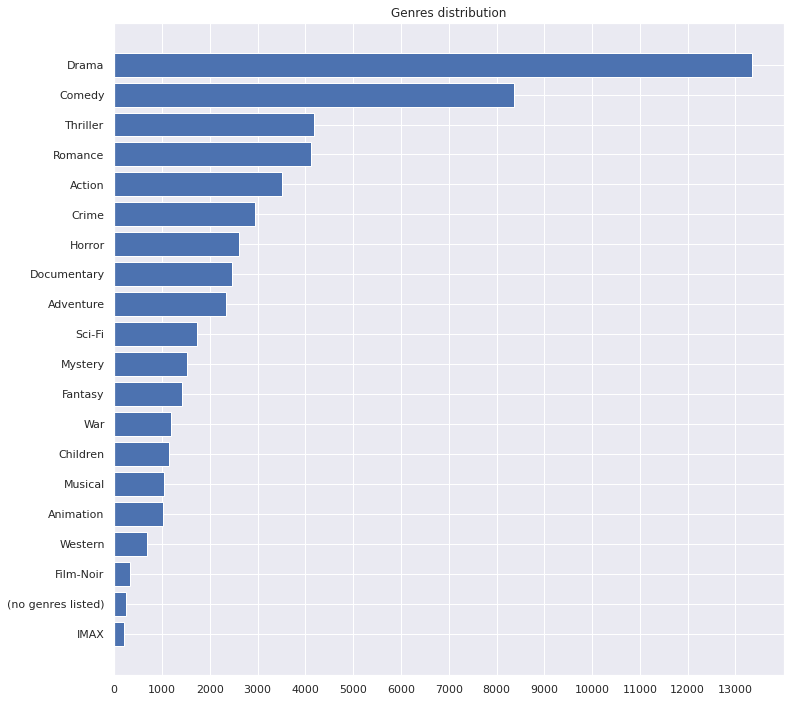

In [9]:
dict_genres = dict(zip(list(unique_genres),list(counts)))
unique_genres, counts = zip(*sorted(dict_genres.items(), key = lambda x: x[1]))
plt.figure(figsize=(12,12))
plt.barh(range(len(unique_genres)),counts)
plt.title('Genres distribution')
plt.yticks(range(len(unique_genres)),unique_genres)
plt.xticks(range(0, max(counts),1000));

## working with genome metadata

In [10]:
genome_scores = pd.read_csv(os.path.join(abs_path, 'genome_scores.csv'))

In [11]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [12]:
genome_scores.shape

(11709768, 3)

In [13]:
genome_scores.tagId.nunique()

1128

In [14]:
genome_scores.movieId.nunique()

10381

In [15]:
genome_scores.relevance.min(), genome_scores.relevance.max()

(0.00024999999999997203, 1.0)

In [16]:
genome_scores = genome_scores[genome_scores['relevance']>0.5]

In [17]:
genome_scores.movieId.nunique()

10381

In [18]:
genome_tags = pd.read_csv(os.path.join(abs_path, 'genome_tags.csv'))

In [19]:
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [20]:
genome_meta = genome_scores.merge(genome_tags, left_on='tagId', right_on='tagId', how='inner')
del genome_scores
del genome_tags
gc.collect();

In [21]:
genome_meta = genome_meta.groupby('movieId').agg({'tag' : list})

In [22]:
unique_genome_tags = np.unique(np.hstack(genome_meta['tag']))

In [23]:
len(unique_genome_tags)

1127

In [24]:
genome_meta['tag'].apply(len).max(), genome_meta['tag'].apply(len).min(),genome_meta['tag'].apply(len).mean()

(201, 1, 44.27049417204508)

In [25]:
movies_meta = movies_meta.merge(genome_meta,left_on='movieId', right_on='movieId', how='left')
del genome_meta
gc.collect();

In [26]:
movies_meta['tag'] = movies_meta['tag'].fillna('unknown').apply(lambda x: x if isinstance(x,list) else [x])

In [27]:
movies_meta['tag']

0        [3d, action, adventure, affectionate, animal m...
1        [action, adventure, animal movie, animals, bas...
2        [chase, comedy, destiny, family, good, great, ...
3        [feel good movie, feel-good, friendship, origi...
4        [chase, comedy, cute!, destiny, family, feel g...
                               ...                        
27273                                            [unknown]
27274                                            [unknown]
27275                                            [unknown]
27276                                            [unknown]
27277                                            [unknown]
Name: tag, Length: 27278, dtype: object

In [28]:
tags, counts = np.unique(np.hstack(movies_meta['tag'].values), return_counts=True)
tags_freq = list(zip(list(tags),list(counts)))
sorted(tags_freq, key = lambda x: x[1])[::-1][:10]

[('unknown', 16897),
 ('original', 10364),
 ('mentor', 5030),
 ('dialogue', 4425),
 ('great ending', 4351),
 ('good soundtrack', 3781),
 ('good', 3435),
 ('story', 3358),
 ('great', 3251),
 ('storytelling', 3127)]

In [29]:
len(tags)

1128

In [30]:
tags, counts = np.unique(np.hstack([i.split(' ') for i in tags]), return_counts=True)
tags_freq = list(zip(list(tags),list(counts)))
sorted(tags_freq, key = lambda x: x[1])[::-1][:10]

[('oscar', 18),
 ('(best', 17),
 ('good', 15),
 ('war', 13),
 ('movie', 11),
 ('nudity', 10),
 ('bad', 10),
 ('on', 9),
 ('comedy', 9),
 ('based', 9)]

# working with user tags

In [31]:
user_tags = pd.read_csv(os.path.join(abs_path, 'tag.csv'))

In [32]:
user_tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [33]:
user_tags = user_tags.sort_values(by='timestamp')

In [34]:
tags, counts = np.unique(np.hstack(user_tags['tag'].values),return_counts=True)
tags_freq = list(zip(list(tags),list(counts)))
sorted(tags_freq, key = lambda x: x[1])[::-1][:10]

[('sci-fi', 3384),
 ('based on a book', 3281),
 ('atmospheric', 2917),
 ('comedy', 2779),
 ('action', 2657),
 ('surreal', 2427),
 ('BD-R', 2334),
 ('twist ending', 2323),
 ('funny', 2072),
 ('dystopia', 1991)]

In [35]:
len(tags_freq)

38644

In [36]:
user_tags['timestamp'].min(), user_tags['timestamp'].max()

('2005-12-24 13:00:10', '2015-03-31 03:09:12')

In [37]:
user_tags = user_tags.groupby('movieId').agg({'tag' : list})

In [38]:
user_tags.head()

,tag
movieId,
1,"[the boys, pixar, classic, Disney, pixar, cgi,..."
2,"[monkey, For children, game, animals, kid flic..."
3,"[Funniest Movies, sequel fever, comedinha de v..."
4,"[revenge, chick flick, characters, characters,..."
5,"[wedding, sequel, family, remake, pregnancy, s..."


In [39]:
user_tags.rename(columns={'tag' : 'user_tags'},inplace=True)
movies_meta = movies_meta.merge(user_tags, left_on='movieId', right_index=True, how='left')

In [40]:
movies_meta.head()

,movieId,title,genres,tag,user_tags
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[3d, action, adventure, affectionate, animal m...","[the boys, pixar, classic, Disney, pixar, cgi,..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[action, adventure, animal movie, animals, bas...","[monkey, For children, game, animals, kid flic..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"[chase, comedy, destiny, family, good, great, ...","[Funniest Movies, sequel fever, comedinha de v..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[feel good movie, feel-good, friendship, origi...","[revenge, chick flick, characters, characters,..."
4,5,Father of the Bride Part II (1995),Comedy,"[chase, comedy, cute!, destiny, family, feel g...","[wedding, sequel, family, remake, pregnancy, s..."


In [41]:
movies_meta['user_tags'] = movies_meta['user_tags'].fillna('unknown').apply(lambda x: x if isinstance(x,list) else [x])

In [42]:
def create_tags(x):
    tag, user_tags = x
    result = []
    if tag[0]=='unknown' and user_tags[0]!='unknown':
        result.extend(user_tags)
    elif (tag[0]!='unknown' and user_tags[0]=='unknown') or (tag[0]=='unknown' and user_tags[0]=='unknown'):
        result.extend(tag)
    else:
        result.extend(tag+user_tags)
    return result

In [43]:
movies_meta['tags'] = movies_meta[['tag','user_tags']].apply(lambda x: create_tags(x),axis=1)
movies_meta.drop(columns=['tag','user_tags'],inplace=True)
movies_meta.head()

,movieId,title,genres,tags
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[3d, action, adventure, affectionate, animal m..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[action, adventure, animal movie, animals, bas..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"[chase, comedy, destiny, family, good, great, ..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[feel good movie, feel-good, friendship, origi..."
4,5,Father of the Bride Part II (1995),Comedy,"[chase, comedy, cute!, destiny, family, feel g..."


In [44]:
del user_tags
gc.collect();

## additional imdb data

In [45]:
links = pd.read_csv(os.path.join(abs_path, 'link.csv'))

In [46]:
links.shape

(27278, 3)

In [47]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [48]:
links['imdbId'] = links['imdbId'].astype(str).apply(lambda x: 'tt'+''.join('0' for i in range(7-len(x)))+x if len(x)<7 else 'tt'+x)

In [49]:
links.head()

,movieId,imdbId,tmdbId
0,1,tt0114709,862.0
1,2,tt0113497,8844.0
2,3,tt0113228,15602.0
3,4,tt0114885,31357.0
4,5,tt0113041,11862.0


In [50]:
imdb_names = pd.read_csv(os.path.join(abs_path, 'imdb_names.csv'))

In [51]:
imdb_names.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0053137,tt0031983,tt0072308,tt0050419"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0037382,tt0117057,tt0071877,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0059956,tt0057345,tt0054452,tt0049189"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0072562,tt0078723,tt0080455,tt0077975"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986"


In [52]:
imdb_names['knownForTitles'] = imdb_names['knownForTitles'].apply(lambda x: x.split(','))

In [53]:
imdb_names = imdb_names.explode('knownForTitles')

In [54]:
imdb_names = imdb_names[imdb_names['knownForTitles']!='\\N']
imdb_names = imdb_names[imdb_names['knownForTitles'].isin(links.imdbId.values)]

In [55]:
imdb_names

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous",tt0053137
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous",tt0031983
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous",tt0072308
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous",tt0050419
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack",tt0037382
...,...,...,...,...,...,...
10477729,nm9993670,Ken Hallen,\N,\N,stunts,tt0969307
10477730,nm9993671,Marko Lampinen,\N,\N,transportation_department,tt0969307
10477731,nm9993672,Simone Hulsemann,\N,\N,miscellaneous,tt0969307
10477732,nm9993673,Petra Jarosova,\N,\N,miscellaneous,tt0969307


In [56]:
imdb_meta = links.merge(imdb_names, left_on='imdbId',right_on='knownForTitles',how='left')

In [57]:
imdb_meta.head()

,movieId,imdbId,tmdbId,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,1,tt0114709,862.0,nm0000741,Tim Allen,1953,\N,"actor,producer,miscellaneous",tt0114709
1,1,tt0114709,862.0,nm0001652,John Ratzenberger,1947,\N,"actor,director,soundtrack",tt0114709
2,1,tt0114709,862.0,nm0001728,Wallace Shawn,1943,\N,"actor,writer,producer",tt0114709
3,1,tt0114709,862.0,nm0001815,Jim Varney,1949,2000,"actor,writer,soundtrack",tt0114709
4,1,tt0114709,862.0,nm0005124,John Lasseter,1957,\N,"producer,writer,director",tt0114709


In [58]:
imdb_meta.shape

(1698357, 9)

In [59]:
imdb_meta = imdb_meta.groupby(['movieId', 'imdbId'], as_index=False).agg({'primaryName' : list})

In [60]:
imdb_meta.shape

(27278, 3)

In [61]:
imdb_meta[imdb_meta['primaryName'].apply(lambda x: True if len(x)==1 else False)]

,movieId,imdbId,primaryName
27,28,tt0114117,[nan]
566,571,tt0111709,[nan]
708,720,tt0118114,[nan]
718,730,tt0125877,[nan]
774,787,tt0113147,[nan]
...,...,...,...
27117,130466,tt4300028,[nan]
27139,130526,tt1534786,[nan]
27181,130970,tt0484855,[nan]
27230,131110,tt1640103,[nan]


In [62]:
imdb_meta['primaryName'] = imdb_meta['primaryName'].apply(lambda x: ['Unknown'] if len(x)==1 else x)

In [63]:
del imdb_names, links
gc.collect();

In [64]:
imdb_basics = pd.read_csv(os.path.join(abs_path, 'imdb_basics.csv'))

/home/volodymyr/envs/linucb_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [65]:
imdb_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [66]:
imdb_basics = imdb_basics[imdb_basics['tconst'].isin(imdb_meta.imdbId.values)]

In [67]:
imdb_basics.isAdult.value_counts()

0    27222
1       10
Name: isAdult, dtype: int64

In [68]:
imdb_basics['titleType'].value_counts()

movie           24514
tvMovie          1033
video             659
short             547
tvMiniSeries      216
tvSpecial         100
tvEpisode          78
tvShort            59
tvSeries           26
Name: titleType, dtype: int64

In [69]:
imdb_basics = imdb_basics.drop(columns=['endYear', 'runtimeMinutes'])

In [70]:
imdb_basics = imdb_basics.drop(columns=['primaryTitle', 'originalTitle'])

In [71]:
imdb_basics.head()

,tconst,titleType,isAdult,startYear,genres
4,tt0000005,short,0,1893,"Comedy,Short"
7,tt0000008,short,0,1894,"Documentary,Short"
9,tt0000010,short,0,1895,"Documentary,Short"
11,tt0000012,short,0,1896,"Action,Documentary,Short"
13,tt0000014,short,0,1895,"Comedy,Short"


In [72]:
imdb_basics['startYear'].unique()

array([1893, 1894, 1895, 1896, 1898, 1902, 1903, 1909, 1910, 1912, 1913,
       1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924,
       1929, 1925, 1926, 1935, 1927, 1928, 1930, 1932, 1931, 1933, 1934,
       1936, 1937, 1946, 1938, 1940, 1939, 1943, 1941, 1942, 1959, 1944,
       2001, 1945, 1947, 1948, 1949, 1952, 1950, 1951, 1953, 1954, 1955,
       1956, 1965, 1957, 1958, 1960, 1962, 1961, 1963, 1964, 1967, 1966,
       1968, 1969, 1970, 1971, 1989, 1972, 1976, 1973, 1990, '1971',
       '1969', '1972', '1970', '1986', '1973', '1967', '1974', '1975',
       '1976', '1977', '1979', '1978', '1980', '1981', '1983', '1982',
       '1987', '1989', '1995', '1985', '1984', '1990', '1988', '2002',
       '1991', '1993', '1992', '1994', '1996', '1997', '2000', '1998',
       '2005', '2001', '1999', '1938', '1963', '1941', '1949', '1966',
       '1957', '1968', '1961', '1955', '1962', '1964', '1965', '1945',
       '1956', '1951', '1934', '1935', '1936', '2006', '1958', '191

In [73]:
imdb_meta = imdb_meta.merge(imdb_basics, left_on='imdbId', right_on='tconst', how='left')

In [74]:
imdb_meta.head()

,movieId,imdbId,primaryName,tconst,titleType,isAdult,startYear,genres
0,1,tt0114709,"[Tim Allen, John Ratzenberger, Wallace Shawn, ...",tt0114709,movie,0.0,1995,"Adventure,Animation,Comedy"
1,2,tt0113497,"[Bonnie Hunt, Bebe Neuwirth, Adam Hann-Byrd, R...",tt0113497,movie,0.0,1995,"Adventure,Comedy,Family"
2,3,tt0113228,"[Richard C. Berman, John Campbell, Monica Cart...",tt0113228,movie,0.0,1995,"Comedy,Romance"
3,4,tt0114885,"[Whitney Houston, Gregory Hines, Kenneth 'Baby...",tt0114885,movie,0.0,1995,"Comedy,Drama,Romance"
4,5,tt0113041,"[Rodrigo Botero, William Akey, Sam Anderson, D...",tt0113041,movie,0.0,1995,"Comedy,Family,Romance"


In [75]:
imdb_meta.shape

(27278, 8)

In [76]:
imdb_meta.isna().any()

movieId        False
imdbId         False
primaryName    False
tconst          True
titleType       True
isAdult         True
startYear       True
genres          True
dtype: bool

In [77]:
imdb_ratings = pd.read_csv(os.path.join(abs_path, 'imdb_ratings.csv'))

In [78]:
imdb_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1656
1,tt0000002,6.1,201
2,tt0000003,6.5,1369
3,tt0000004,6.2,122
4,tt0000005,6.2,2154


In [79]:
imdb_ratings.shape

(1087054, 3)

In [80]:
imdb_meta = imdb_meta.merge(imdb_ratings, left_on='imdbId', right_on='tconst', how='left')

In [81]:
imdb_meta.drop(columns=['tconst_x', 'tconst_y'], inplace=True)

In [82]:
imdb_meta.head()

,movieId,imdbId,primaryName,titleType,isAdult,startYear,genres,averageRating,numVotes
0,1,tt0114709,"[Tim Allen, John Ratzenberger, Wallace Shawn, ...",movie,0.0,1995,"Adventure,Animation,Comedy",8.3,872273.0
1,2,tt0113497,"[Bonnie Hunt, Bebe Neuwirth, Adam Hann-Byrd, R...",movie,0.0,1995,"Adventure,Comedy,Family",7.0,302198.0
2,3,tt0113228,"[Richard C. Berman, John Campbell, Monica Cart...",movie,0.0,1995,"Comedy,Romance",6.7,23870.0
3,4,tt0114885,"[Whitney Houston, Gregory Hines, Kenneth 'Baby...",movie,0.0,1995,"Comedy,Drama,Romance",5.9,9412.0
4,5,tt0113041,"[Rodrigo Botero, William Akey, Sam Anderson, D...",movie,0.0,1995,"Comedy,Family,Romance",6.1,33982.0


In [83]:
imdb_meta.shape

(27278, 9)

In [84]:
imdb_meta.head()

,movieId,imdbId,primaryName,titleType,isAdult,startYear,genres,averageRating,numVotes
0,1,tt0114709,"[Tim Allen, John Ratzenberger, Wallace Shawn, ...",movie,0.0,1995,"Adventure,Animation,Comedy",8.3,872273.0
1,2,tt0113497,"[Bonnie Hunt, Bebe Neuwirth, Adam Hann-Byrd, R...",movie,0.0,1995,"Adventure,Comedy,Family",7.0,302198.0
2,3,tt0113228,"[Richard C. Berman, John Campbell, Monica Cart...",movie,0.0,1995,"Comedy,Romance",6.7,23870.0
3,4,tt0114885,"[Whitney Houston, Gregory Hines, Kenneth 'Baby...",movie,0.0,1995,"Comedy,Drama,Romance",5.9,9412.0
4,5,tt0113041,"[Rodrigo Botero, William Akey, Sam Anderson, D...",movie,0.0,1995,"Comedy,Family,Romance",6.1,33982.0


In [85]:
imdb_meta.isna().any()

movieId          False
imdbId           False
primaryName      False
titleType         True
isAdult           True
startYear         True
genres            True
averageRating     True
numVotes          True
dtype: bool

In [86]:
imdb_meta.rename(columns={'genres' : 'genres_imdb'}, inplace=True)

In [87]:
imdb_meta.head()

,movieId,imdbId,primaryName,titleType,isAdult,startYear,genres_imdb,averageRating,numVotes
0,1,tt0114709,"[Tim Allen, John Ratzenberger, Wallace Shawn, ...",movie,0.0,1995,"Adventure,Animation,Comedy",8.3,872273.0
1,2,tt0113497,"[Bonnie Hunt, Bebe Neuwirth, Adam Hann-Byrd, R...",movie,0.0,1995,"Adventure,Comedy,Family",7.0,302198.0
2,3,tt0113228,"[Richard C. Berman, John Campbell, Monica Cart...",movie,0.0,1995,"Comedy,Romance",6.7,23870.0
3,4,tt0114885,"[Whitney Houston, Gregory Hines, Kenneth 'Baby...",movie,0.0,1995,"Comedy,Drama,Romance",5.9,9412.0
4,5,tt0113041,"[Rodrigo Botero, William Akey, Sam Anderson, D...",movie,0.0,1995,"Comedy,Family,Romance",6.1,33982.0


In [87]:
del imdb_ratings, imdb_basics;
gc.collect();

## merging with movilens meta

In [88]:
movies_meta = movies_meta.merge(imdb_meta, left_on='movieId', right_on='movieId', how='inner')

In [89]:
movies_meta.head()

,movieId,title,genres,tags,imdbId,primaryName,titleType,isAdult,startYear,genres_imdb,averageRating,numVotes
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[3d, action, adventure, affectionate, animal m...",tt0114709,"[Tim Allen, John Ratzenberger, Wallace Shawn, ...",movie,0.0,1995,"Adventure,Animation,Comedy",8.3,872273.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[action, adventure, animal movie, animals, bas...",tt0113497,"[Bonnie Hunt, Bebe Neuwirth, Adam Hann-Byrd, R...",movie,0.0,1995,"Adventure,Comedy,Family",7.0,302198.0
2,3,Grumpier Old Men (1995),Comedy|Romance,"[chase, comedy, destiny, family, good, great, ...",tt0113228,"[Richard C. Berman, John Campbell, Monica Cart...",movie,0.0,1995,"Comedy,Romance",6.7,23870.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[feel good movie, feel-good, friendship, origi...",tt0114885,"[Whitney Houston, Gregory Hines, Kenneth 'Baby...",movie,0.0,1995,"Comedy,Drama,Romance",5.9,9412.0
4,5,Father of the Bride Part II (1995),Comedy,"[chase, comedy, cute!, destiny, family, feel g...",tt0113041,"[Rodrigo Botero, William Akey, Sam Anderson, D...",movie,0.0,1995,"Comedy,Family,Romance",6.1,33982.0


In [90]:
movies_meta['year_movilens'] = movies_meta['title'].str.findall('[(][1-2][0-9][0-9][0-9][)]')

In [91]:
movies_meta['year_movilens'] = movies_meta['year_movilens'].apply(lambda x: x[0].replace('(','').replace(')','') if x else 0 )

In [92]:
movies_meta['startYear'].isna().sum()

46

In [93]:
movies_meta['startYear'] = movies_meta['startYear'].fillna(movies_meta['year_movilens'])
(movies_meta['startYear']==0).sum()

0

In [94]:
movies_meta.isna().sum()

movieId           0
title             0
genres            0
tags              0
imdbId            0
primaryName       0
titleType        46
isAdult          46
startYear         0
genres_imdb      46
averageRating    63
numVotes         63
year_movilens     0
dtype: int64

In [95]:
movies_meta['genres_imdb'] = movies_meta['genres_imdb'].fillna('unknown')

In [96]:
np.unique(np.hstack(movies_meta['genres_imdb'].astype(str).apply(lambda x: x.split(',')).values))

array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show',
       'Thriller', 'War', 'Western', '\\N', 'unknown'], dtype='<U11')

In [97]:
movies_meta['genres_imdb'] = movies_meta['genres_imdb'].apply(lambda x: 'unknown' if x=='\\N' else x)

In [98]:
np.unique(np.hstack(movies_meta['genres_imdb'].astype(str).apply(lambda x: x.split(',')).values))

array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show',
       'Thriller', 'War', 'Western', 'unknown'], dtype='<U11')

In [99]:
def merge_genres(x):
    imdb_genres, movilens_genres = x
    new_genres = set()
    if movilens_genres=='(no genres listed)' and imdb_genres!='unknown':
        new_genres.update(imdb_genres.split(','))
    elif movilens_genres!='(no genres listed)' and imdb_genres=='unknown':
        new_genres.update(movilens_genres.split('|'))
    elif movilens_genres!='(no genres listed)' and imdb_genres!='unknown':
        new_genres.update(movilens_genres.split('|'))
        new_genres.update(imdb_genres.split(','))
    else:
        new_genres.add('unknown')
    return list(new_genres)

In [100]:
movies_meta['genres'] = movies_meta[['genres_imdb','genres']].apply(merge_genres, axis=1)
movies_meta.drop(columns='genres_imdb',inplace=True)

In [101]:
movies_meta[movies_meta['genres'].apply(lambda x: x[0]=='unknown')]

,movieId,title,genres,tags,imdbId,primaryName,titleType,isAdult,startYear,averageRating,numVotes,year_movilens
16574,83773,Away with Words (San tiao ren) (1999),[unknown],[unknown],tt0213469,[Unknown],NaN,NaN,1999,NaN,NaN,1999
27014,129849,Old Man Drinking a Glass of Beer (1898),[unknown],[unknown],tt1604139,[Unknown],NaN,NaN,1898,NaN,NaN,1898


In [102]:
movies_meta.drop(columns='year_movilens',inplace=True)

In [103]:
movies_meta.isna().sum()

movieId           0
title             0
genres            0
tags              0
imdbId            0
primaryName       0
titleType        46
isAdult          46
startYear         0
averageRating    63
numVotes         63
dtype: int64

In [104]:
movies_meta[movies_meta['genres'].apply(lambda x: True if 'Adult' in x else False)]['isAdult'].value_counts()

1.0    6
Name: isAdult, dtype: int64

In [105]:
movies_meta[movies_meta['genres'].apply(lambda x: True if 'Children' in x else False)]['isAdult'].value_counts()

0.0    1136
Name: isAdult, dtype: int64

In [106]:
movies_meta['titleType'].value_counts()

movie           24514
tvMovie          1033
video             659
short             547
tvMiniSeries      216
tvSpecial         100
tvEpisode          78
tvShort            59
tvSeries           26
Name: titleType, dtype: int64

In [107]:
movies_meta['titleType'] = movies_meta['titleType'].fillna('movie')

In [108]:
movies_meta['averageRating'] = movies_meta['averageRating'].fillna(-1)
movies_meta['numVotes'] = movies_meta['numVotes'].fillna(-1)

In [109]:
movies_meta.isna().sum()

movieId           0
title             0
genres            0
tags              0
imdbId            0
primaryName       0
titleType         0
isAdult          46
startYear         0
averageRating     0
numVotes          0
dtype: int64

In [110]:
movies_meta[movies_meta['isAdult'].isna()]

,movieId,title,genres,tags,imdbId,primaryName,titleType,isAdult,startYear,averageRating,numVotes
708,720,Wallace & Gromit: The Best of Aardman Animatio...,"[Adventure, Comedy, Animation]","[animation, clever, comedy, cool, dialogue, fu...",tt0118114,[Unknown],movie,NaN,1996,-1.0,-1.0
2173,2258,"Master, The (1984)",[Action],[ninja],tt0087690,[Unknown],movie,NaN,1984,-1.0,-1.0
2425,2510,Just the Ticket (1999),"[Comedy, Romance]","[cute!, destiny, feel-good, good, good soundtr...",tt0134948,[Unknown],movie,NaN,1999,-1.0,-1.0
2765,2851,Saturn 3 (1980),"[Adventure, Sci-Fi, Thriller]","[dialogue, mentor, original, technology, visua...",tt0081454,[Unknown],movie,NaN,1980,-1.0,-1.0
2913,2999,Man of the Century (1999),[Comedy],"[dialogue, fun, good soundtrack, nostalgic, or...",tt0154827,[Unknown],movie,NaN,1999,-1.0,-1.0
3957,4051,Horrors of Spider Island (Ein Toter Hing im Ne...,"[Horror, Sci-Fi]","[dialogue, original, predictable, spiders, wom...",tt0056600,[Unknown],movie,NaN,1960,-1.0,-1.0
4147,4241,Pokémon 3: The Movie (2001),"[Children, Animation]","[adventure, animation, childhood, computer ani...",tt0266860,[Unknown],movie,NaN,2001,-1.0,-1.0
5167,5264,Clockstoppers (2002),"[Adventure, Sci-Fi, Thriller, Action]","[adventure, children, family, fun, fun movie, ...",tt0250305,[Unknown],movie,NaN,2002,-1.0,-1.0
5306,5403,"Sleepy Time Gal, The (2001)",[Drama],[unknown],tt0277322,[Unknown],movie,NaN,2001,-1.0,-1.0
5573,5672,Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (...,"[Adventure, Fantasy, Children, Animation]","[action, adventure, animals, animation, colour...",tt0313487,[Unknown],movie,NaN,2002,-1.0,-1.0


In [111]:
movies_meta.loc[movies_meta['isAdult'].isna(), 'isAdult'] = movies_meta\
.loc[movies_meta['isAdult'].isna(), 'genres']\
.apply(lambda x: 1 if ('Horror' in x) or ('Thriller' in x) else 0)

In [112]:
movies_meta.isna().sum()

movieId          0
title            0
genres           0
tags             0
imdbId           0
primaryName      0
titleType        0
isAdult          0
startYear        0
averageRating    0
numVotes         0
dtype: int64

In [113]:
movies_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27278 entries, 0 to 27277
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title          27278 non-null  object 
 2   genres         27278 non-null  object 
 3   tags           27278 non-null  object 
 4   imdbId         27278 non-null  object 
 5   primaryName    27278 non-null  object 
 6   titleType      27278 non-null  object 
 7   isAdult        27278 non-null  float64
 8   startYear      27278 non-null  object 
 9   averageRating  27278 non-null  float64
 10  numVotes       27278 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 2.5+ MB


In [114]:
movies_meta['numVotes'].max(), movies_meta['movieId'].max()

(2300783.0, 131262)

In [115]:
movies_meta['isAdult'] = movies_meta['isAdult'].astype('uint8')
movies_meta['numVotes'] = movies_meta['numVotes'].astype('int32')
movies_meta['averageRating'] = movies_meta['averageRating'].astype('float16')
movies_meta['movieId'] = movies_meta['movieId'].astype('int32')

In [116]:
del imdb_meta;
gc.collect();

In [117]:
movies_meta.head()

,movieId,title,genres,tags,imdbId,primaryName,titleType,isAdult,startYear,averageRating,numVotes
0,1,Toy Story (1995),"[Comedy, Children, Adventure, Fantasy, Animation]","[3d, action, adventure, affectionate, animal m...",tt0114709,"[Tim Allen, John Ratzenberger, Wallace Shawn, ...",movie,0,1995,8.296875,872273
1,2,Jumanji (1995),"[Comedy, Children, Family, Adventure, Fantasy]","[action, adventure, animal movie, animals, bas...",tt0113497,"[Bonnie Hunt, Bebe Neuwirth, Adam Hann-Byrd, R...",movie,0,1995,7.000000,302198
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[chase, comedy, destiny, family, good, great, ...",tt0113228,"[Richard C. Berman, John Campbell, Monica Cart...",movie,0,1995,6.699219,23870
3,4,Waiting to Exhale (1995),"[Romance, Comedy, Drama]","[feel good movie, feel-good, friendship, origi...",tt0114885,"[Whitney Houston, Gregory Hines, Kenneth 'Baby...",movie,0,1995,5.898438,9412
4,5,Father of the Bride Part II (1995),"[Family, Comedy, Romance]","[chase, comedy, cute!, destiny, family, feel g...",tt0113041,"[Rodrigo Botero, William Akey, Sam Anderson, D...",movie,0,1995,6.101562,33982


In [118]:
len(np.hstack(movies_meta['primaryName']))

1698357

In [119]:
len(np.unique(np.hstack(movies_meta['primaryName'])))

986915

In [120]:
unique_names, counts = np.unique(np.hstack(movies_meta['primaryName']), return_counts=True)

In [121]:
unique_counts = dict(sorted(dict(zip(unique_names, counts)).items(), key = lambda x: x[1])[::-1])
print(len(unique_counts))

986915
18923


In [ ]:
unique_counts.items()

In [ ]:
import os
if not os.path.exists('../processed_data'):
    os.mkdir('../processed_data')

In [ ]:
movies_meta.to_csv('../processed_data/metadata.csv', index=False)